In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## TODO: Remove later
_Code Refs_
https://github.com/tensorflow/tensorflow/blob/r2.0/tensorflow/lite/python/tflite_convert.py#L104
`converter_fn = lite.TFLiteConverter.from_keras_model_file
converter_kwargs["model_file"] = flags.keras_model_file`

Actual code in:
https://www.gitmemory.com/gargn
'''
model = tf.saved_model.load(export_dir)
concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 28, 28])
converter = tf.lite.TFLiteConverter.from_concrete_function(concrete_func)
tflite_model = converter.convert()
open("/tmp/mnist_fashion/converted_model.tflite", "wb").write(tflite_model)
'''
Note that the model has been saved with tf.saved_model, and not with keras convience function.

    

In [7]:
import sys
sys.path.append('../')  # so that we can import libs from other chapters and utils

from utils import emnist_utils

In [11]:
# Load train and test data from Chapter 1 location
train = {}
test = {}

train['features'], train['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-train-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-test-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-test-labels-idx1-ubyte.gz')

In [12]:
mappings = emnist_utils.map_emnist_labels("../Chapter1/data/emnist-bymerge-mapping.txt")

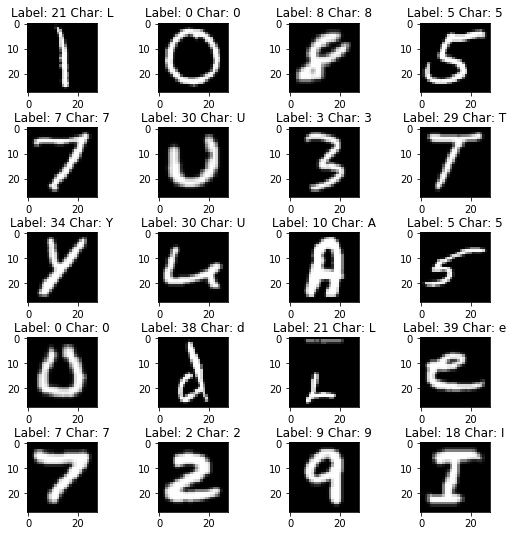

In [13]:
# Plot some images to verify we got the data right
emnist_utils.display_emnist_images(train['features'], train['labels'], mappings)

In [14]:
# Normalize the data
norm_train_features = keras.utils.normalize(train['features'])
norm_test_features = keras.utils.normalize(test['features'])

# one hot encode training labels
one_hot_train_labels = tf.one_hot(train['labels'], 47)
one_hot_test_labels = tf.one_hot(test['labels'], 47)

## Our first Convolutional Neural Network

In [21]:
# First the input layers
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_1')
cnn.summary()


Model: "cnn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2769152   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               

In [22]:
# Lets compile the model and train it
cnn.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = cnn.fit(train['features'], one_hot_train_labels, epochs=5, batch_size=128)

Epoch 1/5
321280/697932 [============>.................] - ETA: 2:10 - loss: 0.3998 - accuracy: 0.8638